# Uber Fare Prediction

In [1]:
pip install geopy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import math
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import geopy.distance
from tqdm import tqdm
from IPython.display import display

import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd

#read the csv file
df = pd.read_csv("C:/Users/aksha/Downloads/uber.csv/uber.csv")

# Displaying the first 5 rows of the data
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


# Data Exploration

In [4]:
# Checking for null values
print(df.isnull().sum())

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64


In [6]:
#Replacing the null values with it's mean value
df['dropoff_longitude'].fillna(df['dropoff_longitude'].mean(), inplace=True)
df['dropoff_latitude'].fillna(df['dropoff_latitude'].mean(), inplace=True)

print(df.isnull().sum())

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


In [7]:
df = df[(df.pickup_latitude<90) & (df.dropoff_latitude<90) &
        (df.pickup_latitude>-90) & (df.dropoff_latitude>-90) &
        (df.pickup_longitude<180) & (df.dropoff_longitude<180) &
        (df.pickup_longitude>-180) & (df.dropoff_longitude>-180)]

Ensuring that pickup and dropoff coordinates are within valid geographic ranges i.e., 
###### Latitude must be between -90 and 90 ; 
###### Longitude must be between -180 and 180

In [8]:
#Converting pickup_datetime to DateTime Format
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)

df['year'] = df.pickup_datetime.dt.year   #Extracting date components
df['month'] = df.pickup_datetime.dt.month
df['weekday'] = df.pickup_datetime.dt.weekday
df['hour'] = df.pickup_datetime.dt.hour
df

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,weekday,hour
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,3,19
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,4,20
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,0,21
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,4,8
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,3,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00+00:00,-73.987042,40.739367,-73.986525,40.740297,1,2012,10,6,10
199996,16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00+00:00,-73.984722,40.736837,-74.006672,40.739620,1,2014,3,4,1
199997,27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00+00:00,-73.986017,40.756487,-73.858957,40.692588,2,2009,6,0,0
199998,20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25+00:00,-73.997124,40.725452,-73.983215,40.695415,1,2015,5,2,14


In [9]:
#Seggregating months to their respective quarters(Q1, Q2, Q3, Q4) 
df['Monthly_Quarter'] = df.month.map({1:'Q1',2:'Q1',3:'Q1',4:'Q2',5:'Q2',6:'Q2',7:'Q3',8:'Q3',9:'Q3',10:'Q4',11:'Q4',12:'Q4'})
df

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,weekday,hour,Monthly_Quarter
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,3,19,Q2
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,4,20,Q3
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,0,21,Q3
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,4,8,Q2
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,3,17,Q3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00+00:00,-73.987042,40.739367,-73.986525,40.740297,1,2012,10,6,10,Q4
199996,16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00+00:00,-73.984722,40.736837,-74.006672,40.739620,1,2014,3,4,1,Q1
199997,27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00+00:00,-73.986017,40.756487,-73.858957,40.692588,2,2009,6,0,0,Q2
199998,20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25+00:00,-73.997124,40.725452,-73.983215,40.695415,1,2015,5,2,14,Q2


In [10]:
#Seggregating hours to their hourly segments to analyze rush hours or time of day.
df['Hourly_Segments'] = df.hour.map({0:'H1',1:'H1',2:'H1',3:'H1',4:'H2',5:'H2',6:'H2',7:'H2',
                                     8:'H3',9:'H3',10:'H3',11:'H3',12:'H4',13:'H4',14:'H4',
                                     15:'H4',16:'H5',17:'H5',18:'H5',19:'H5',20:'H6',
                                     21:'H6',22:'H6',23:'H6'})
df

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,weekday,hour,Monthly_Quarter,Hourly_Segments
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,3,19,Q2,H5
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,4,20,Q3,H6
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,0,21,Q3,H6
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,4,8,Q2,H3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,3,17,Q3,H5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00+00:00,-73.987042,40.739367,-73.986525,40.740297,1,2012,10,6,10,Q4,H3
199996,16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00+00:00,-73.984722,40.736837,-74.006672,40.739620,1,2014,3,4,1,Q1,H1
199997,27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00+00:00,-73.986017,40.756487,-73.858957,40.692588,2,2009,6,0,0,Q2,H1
199998,20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25+00:00,-73.997124,40.725452,-73.983215,40.695415,1,2015,5,2,14,Q2,H4


where, 

H1: Midnight to 3 AM ; H2: 4 AM to 7 AM ; H3: 8 AM to 11 AM ; 
H4: Noon to 3 PM ; H5: 4 PM to 7 PM ; H6: 8 PM to 11 PM

In [12]:
#Calculating the distance between pick-up and drop-off locations
import geopy.distance

def calculate_distance(row):
    coords_1 = (row['pickup_latitude'], row['pickup_longitude'])
    coords_2 = (row['dropoff_latitude'], row['dropoff_longitude'])
    return round(geopy.distance.distance(coords_1, coords_2).m, 2)

df['Distance'] = df.apply(calculate_distance, axis=1)

In [13]:
#dropping unnecessary columns
df.drop(['pickup_datetime', 'month', 'hour','Unnamed: 0','key'], axis=1, inplace=True)

In [14]:
original_df = df.copy(deep=True)
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,Monthly_Quarter,Hourly_Segments,Distance
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,3,Q2,H5,1681.11
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,4,Q3,H6,2454.36
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,0,Q3,H6,5039.60
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,4,Q2,H3,1661.44
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,2014,3,Q3,H5,4483.73


In [15]:
df.info() #Checking dtypes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199988 entries, 0 to 199999
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        199988 non-null  float64
 1   pickup_longitude   199988 non-null  float64
 2   pickup_latitude    199988 non-null  float64
 3   dropoff_longitude  199988 non-null  float64
 4   dropoff_latitude   199988 non-null  float64
 5   passenger_count    199988 non-null  int64  
 6   year               199988 non-null  int64  
 7   weekday            199988 non-null  int64  
 8   Monthly_Quarter    199988 non-null  object 
 9   Hourly_Segments    199988 non-null  object 
 10  Distance           199988 non-null  float64
dtypes: float64(6), int64(3), object(2)
memory usage: 22.3+ MB


In [16]:
#number of unique rows in each feature
df.nunique().sort_values()

Monthly_Quarter           4
Hourly_Segments           6
year                      7
weekday                   7
passenger_count           8
fare_amount            1244
pickup_longitude      71056
dropoff_longitude     76891
pickup_latitude       83831
dropoff_latitude      90583
Distance             164543
dtype: int64

In [17]:
#Defining the target variable 
target = 'fare_amount' 
nu = df.drop([target], axis=1).nunique().sort_values()
nf = []  # Numerical features
cf = []  # Categorical features

for i in range(df.drop([target], axis=1).shape[1]):
    if nu.values[i] <= 24:  # If unique values are <= 24, consider it categorical
        cf.append(nu.index[i])
    else:
        nf.append(nu.index[i])

# Print the results
print('\n\033[1mInference:\033[0m The Dataset has {} numerical & {} categorical features.'.format(len(nf), len(cf)))
print('\n\033[1mNumerical Features:\033[0m', nf)
print('\n\033[1mCategorical Features:\033[0m', cf)


Inference: The Dataset has 5 numerical & 5 categorical features.

Numerical Features: ['pickup_longitude', 'dropoff_longitude', 'pickup_latitude', 'dropoff_latitude', 'Distance']

Categorical Features: ['Monthly_Quarter', 'Hourly_Segments', 'year', 'weekday', 'passenger_count']


In [18]:
#checking stats of all columns
display(df.describe())

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,Distance
count,199988.000000,199988.000000,199988.000000,199988.000000,199988.000000,199988.000000,199988.000000,199988.000000,1.999880e+05
mean,11.359913,-72.501793,39.917941,-72.511608,39.922031,1.684536,2011.742470,3.048373,2.056413e+04
std,9.901884,10.449930,6.130396,10.412166,6.117653,1.386001,1.856435,1.946961,3.796629e+05
min,-52.000000,-93.824668,-74.015515,-75.458979,-74.015750,0.000000,2009.000000,0.000000,0.000000e+00
25%,6.000000,-73.992064,40.734794,-73.991407,40.733823,1.000000,2010.000000,1.000000,1.215535e+03
50%,8.500000,-73.981822,40.752592,-73.980092,40.753042,1.000000,2012.000000,3.000000,2.121295e+03
75%,12.500000,-73.967154,40.767157,-73.963658,40.768000,2.000000,2013.000000,5.000000,3.874318e+03
max,499.000000,40.808425,48.018760,40.831932,45.031598,208.000000,2015.000000,6.000000,8.783594e+06


# Exploratory Data Analysis (EDA)

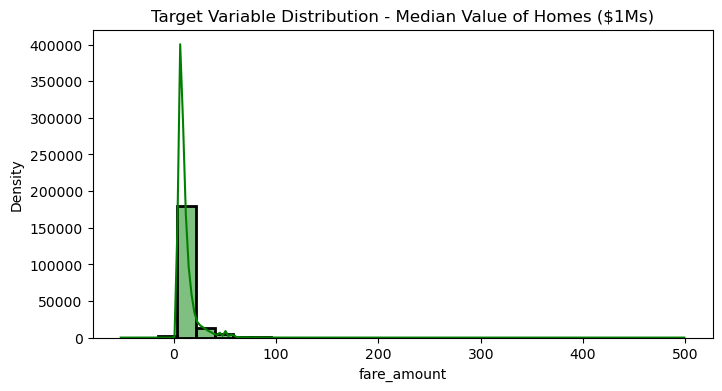

In [19]:
#Visualising the target variable
#Plot the distribution of fare_amount
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=[8, 4])
sns.histplot(df[target], color='g', edgecolor="black", linewidth=2, bins=30, kde=True)
plt.title('Target Variable Distribution - Median Value of Homes ($1Ms)')
plt.xlabel('fare_amount') 
plt.ylabel('Density')
plt.show()

The Target Variable (fare_amount) seems to be be highly skewed, with most datapoints lieing near 0.

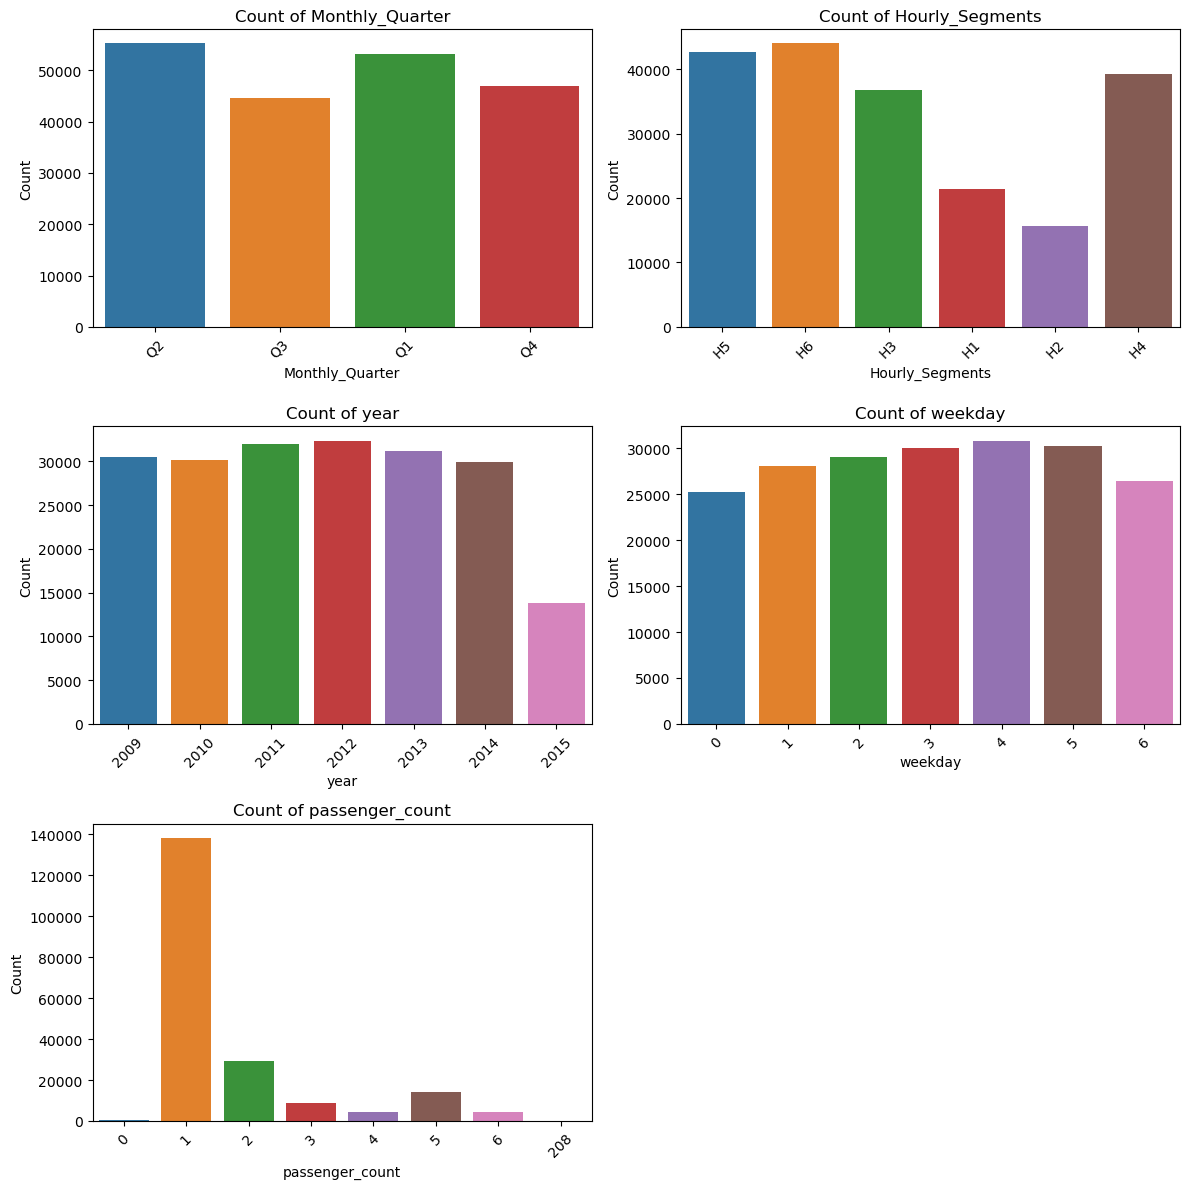

In [31]:
#Visualising list of categorical features
categorical_features = ['Monthly_Quarter', 'Hourly_Segments', 'year', 'weekday', 'passenger_count']
fig, axs = plt.subplots(3, 2, figsize=(12, 12)) 
axs = axs.flatten()

# Plotting each categorical feature
for i, feature in enumerate(categorical_features):
    sns.countplot(data=df, x=feature, ax=axs[i])
    axs[i].set_title(f'Count of {feature}')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Count')
    axs[i].tick_params(axis='x', rotation=45)

#Hiding unnecessary subplots
for j in range(len(categorical_features), len(axs)):
    fig.delaxes(axs[j])
    
# Adjust layout
plt.tight_layout()
plt.show()

In [44]:
# Aggregate the data by passenger_count to find the mean fare_amount for each count
fare_by_passenger = df.groupby('passenger_count')['fare_amount'].mean().reset_index()

# Calculate fare differences
fare_diff = fare_by_passenger['fare_amount'].diff().fillna(0)

# To analyze trends
increase_count = (fare_diff > 0).sum()
decrease_count = (fare_diff < 0).sum()
constant_count = (fare_diff == 0).sum()

print(f"How Passenger Count Affects Fare Amount:")
print(f"- {increase_count} instances where an increase in passenger count leads to an increase in fare.")
print(f"- {decrease_count} instances where an increase in passenger count leads to a decrease in fare.")
print(f"- {constant_count} instances where the fare remains the same across different passenger counts.")

for i in range(1, len(fare_by_passenger)):
    print(f"Difference in fare between passenger count {fare_by_passenger['passenger_count'].iloc[i-1]} and {fare_by_passenger['passenger_count'].iloc[i]}: {fare_diff[i]:.2f}")

How Passenger Count Affects Fare Amount:
- 4 instances where an increase in passenger count leads to an increase in fare.
- 3 instances where an increase in passenger count leads to a decrease in fare.
- 1 instances where the fare remains the same across different passenger counts.
Difference in fare between passenger count 0 and 1: 1.80
Difference in fare between passenger count 1 and 2: 0.53
Difference in fare between passenger count 2 and 3: -0.30
Difference in fare between passenger count 3 and 4: 0.15
Difference in fare between passenger count 4 and 5: -0.44
Difference in fare between passenger count 5 and 6: 0.96
Difference in fare between passenger count 6 and 208: -0.46


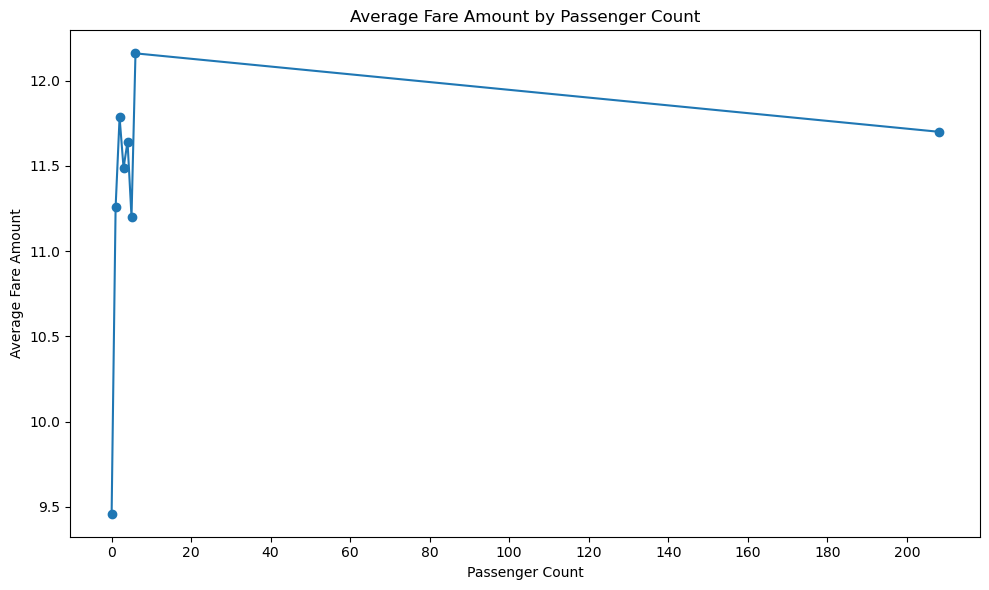

In [45]:
# Creating a line plot
plt.figure(figsize=(10, 6))
plt.plot(fare_by_passenger['passenger_count'], fare_by_passenger['fare_amount'], marker='o')
plt.xticks(range(0, fare_by_passenger['passenger_count'].max() + 1, 20))
plt.title('Average Fare Amount by Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Average Fare Amount')
plt.tight_layout()
plt.show()

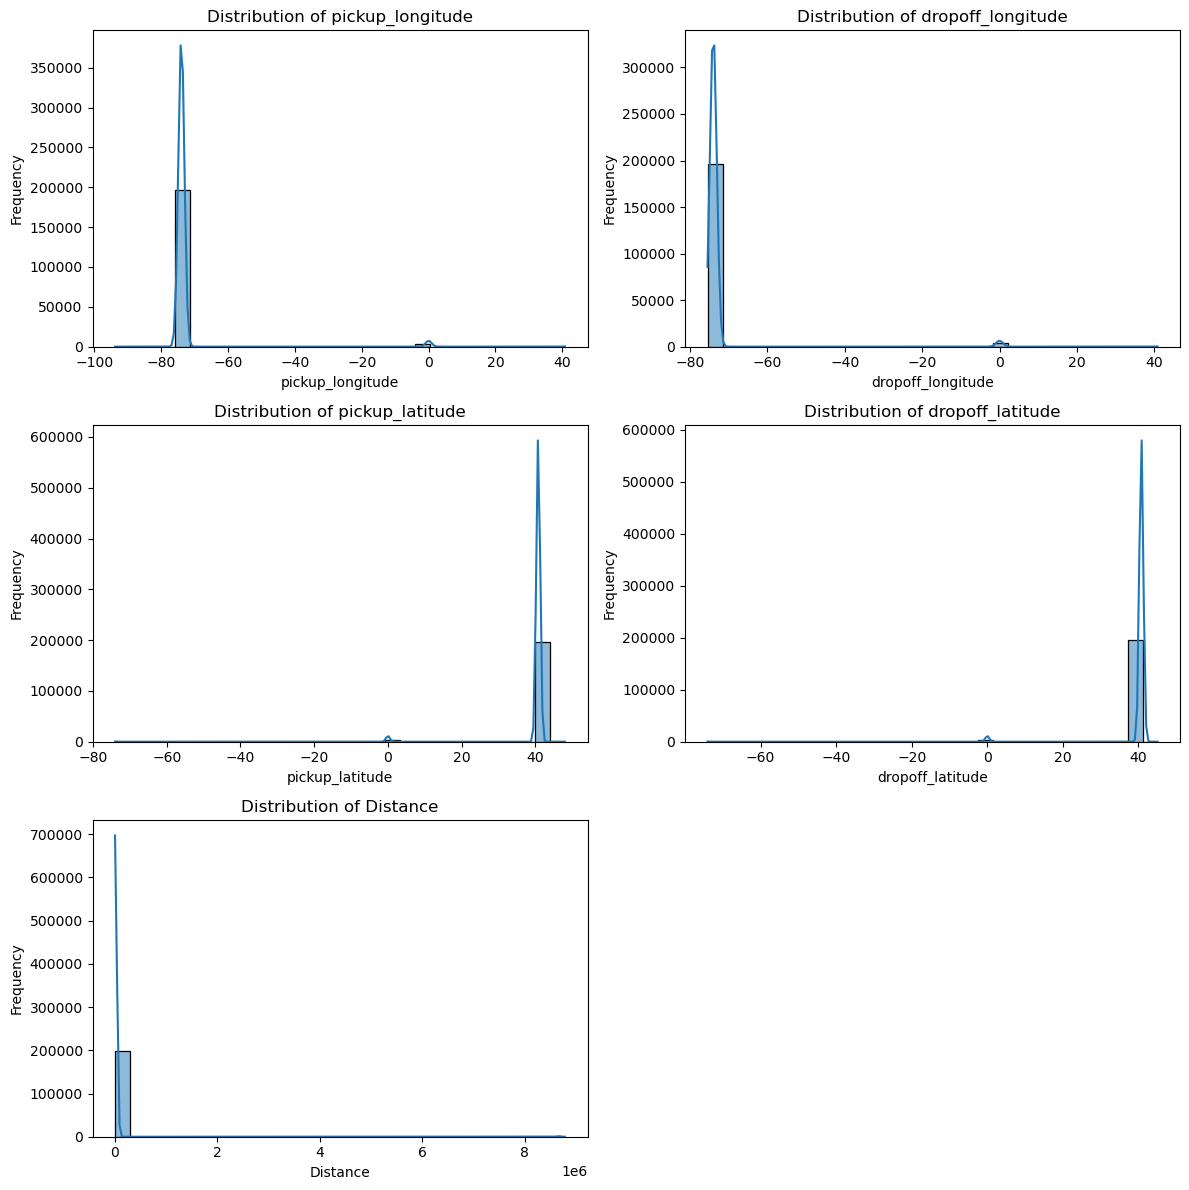

In [46]:
#Visualising the list of numerical features
numerical_features = ['pickup_longitude', 'dropoff_longitude', 'pickup_latitude', 'dropoff_latitude', 'Distance']
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
axs = axs.flatten()

# Plot each numerical feature
for i, feature in enumerate(numerical_features):
    sns.histplot(df[feature], bins=30, kde=True, ax=axs[i], edgecolor="black")
    axs[i].set_title(f'Distribution of {feature}')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Frequency')

#Hiding unnecessary subplots
for j in range(len(numerical_features), len(axs)):
    fig.delaxes(axs[j])

# Adjust layout
plt.tight_layout()
plt.show()

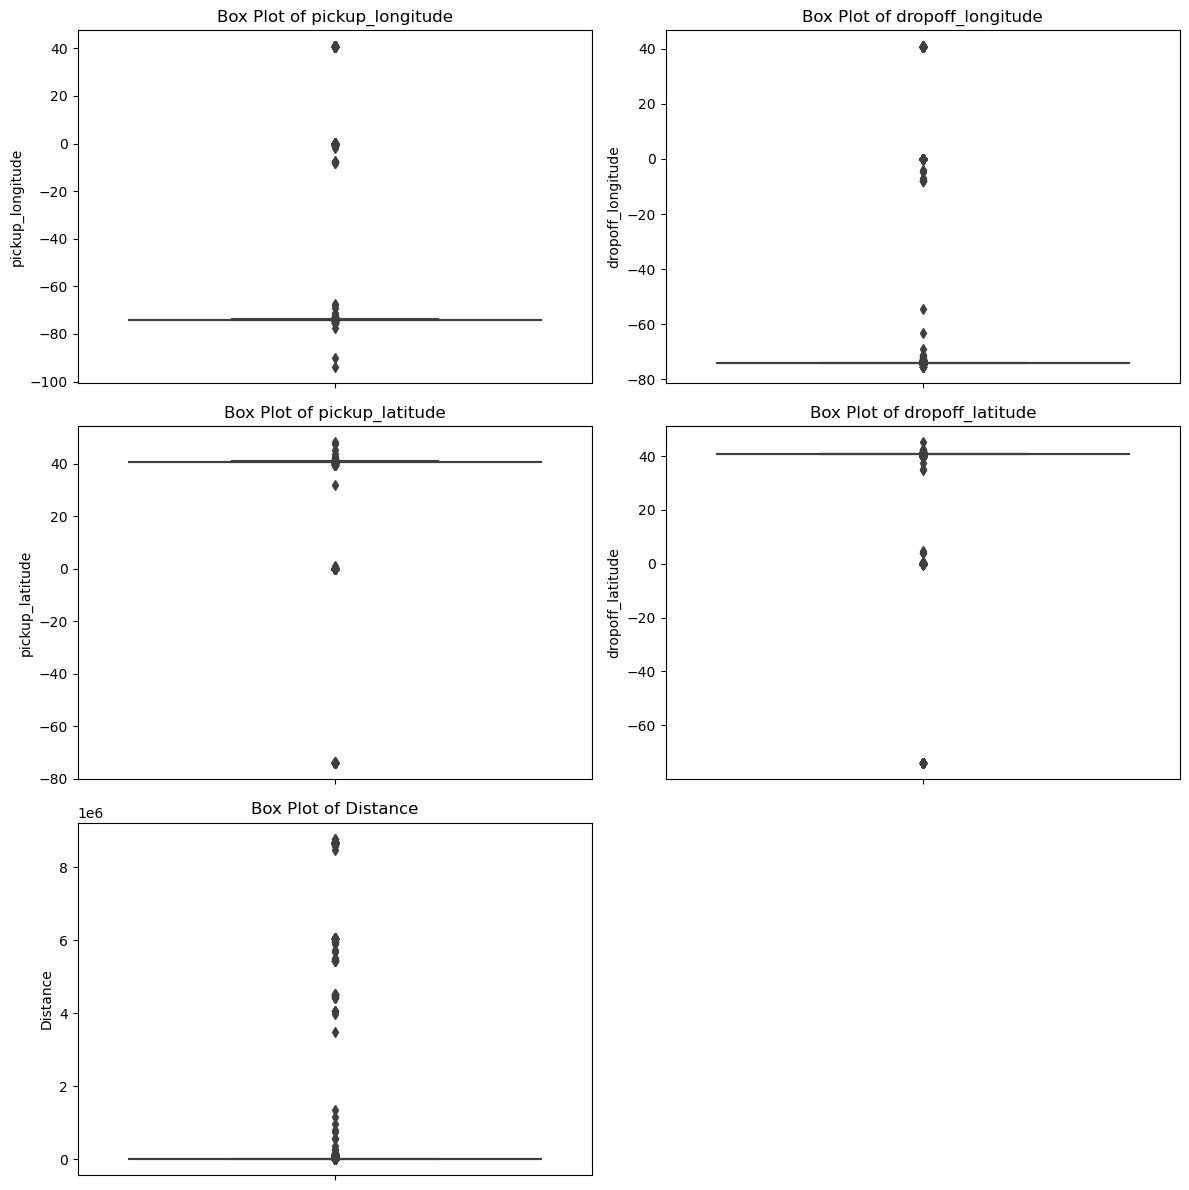

In [47]:
#Visualising the list of numerical features on box plot
numerical_features = ['pickup_longitude', 'dropoff_longitude', 'pickup_latitude', 'dropoff_latitude', 'Distance']
fig, axs = plt.subplots(3, 2, figsize=(12, 12)) 
axs = axs.flatten()
for i, feature in enumerate(numerical_features):
    sns.boxplot(data=df, y=feature, ax=axs[i]) 
    axs[i].set_title(f'Box Plot of {feature}')
    axs[i].set_ylabel(feature)
    
#Hiding unnecessary subplots
for j in range(len(numerical_features), len(axs)):
    fig.delaxes(axs[j])

# Adjust layout
plt.tight_layout()
plt.show()

There seem to be some outliers in these features. To handle these outliers, I want to choose Interquartile Range (IQR) method, which uses the 25th and 75th percentiles to identify outliers.

In [48]:
# Remove duplicate rows
df.drop_duplicates(inplace=True)
df

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,Monthly_Quarter,Hourly_Segments,Distance
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,3,Q2,H5,1681.11
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,4,Q3,H6,2454.36
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,0,Q3,H6,5039.60
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,4,Q2,H3,1661.44
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,2014,3,Q3,H5,4483.73
...,...,...,...,...,...,...,...,...,...,...,...
199995,3.0,-73.987042,40.739367,-73.986525,40.740297,1,2012,6,Q4,H3,112.13
199996,7.5,-73.984722,40.736837,-74.006672,40.739620,1,2014,4,Q1,H1,1879.64
199997,30.9,-73.986017,40.756487,-73.858957,40.692588,2,2009,0,Q2,H1,12867.92
199998,14.5,-73.997124,40.725452,-73.983215,40.695415,1,2015,2,Q2,H4,3536.55


In [49]:
#Converting Categorical Columns to Numeric
df3 = df.copy() # Making a copy of the original DataFrame

for col in cf:
    if df3[col].nunique() == 2:
        df3[col] = pd.get_dummies(df3[col], drop_first=True)  # One-Hot Encoding for binary columns
    elif 2 < df3[col].nunique() < 17:
        df3 = pd.get_dummies(df3, columns=[col], drop_first=True, prefix=col)  # Dummy Encoding

# Output the new shape of the DataFrame
print(f"New DataFrame shape: {df3.shape}")

New DataFrame shape: (199879, 33)


### Interquartile Range (IQR) method
Calculate the first (Q1) and third (Q3) quartiles ; 
Q1 = The value below which 25% of the data lies ;
Q3 = The value below which 75% of the data lies.

IQR = (Q3 - Q1)

Define lower and upper bounds.
where,
Lower Bound=Q1−1.5×IQR ;
Upper Bound=Q3+1.5×IQR

Remove data points outside these bounds.

In [50]:
# Make a copy of the df
df1 = df3.copy()

# List of features to check for outliers
features1 = nf 

# Remove outliers using IQR for each feature
for feature in features1:
    Q1 = df1[feature].quantile(0.25)
    Q3 = df1[feature].quantile(0.75)
    IQR = Q3 - Q1

    # Filter out outliers
    df1 = df1[(df1[feature] >= (Q1 - 1.5 * IQR)) & (df1[feature] <= (Q3 + 1.5 * IQR))]

# Reset index
df1.reset_index(drop=True, inplace=True)
display(df1.head())

print(f'Before removal: {df3.shape[0]} samples;\nAfter removal: {df1.shape[0]} samples.')

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Distance,Monthly_Quarter_Q2,Monthly_Quarter_Q3,Monthly_Quarter_Q4,Hourly_Segments_H2,...,weekday_4,weekday_5,weekday_6,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_208
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1681.11,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,7.7,-73.994355,40.728225,-73.994710,40.750325,2454.36,0,1,0,0,...,1,0,0,1,0,0,0,0,0,0
2,12.9,-74.005043,40.740770,-73.962565,40.772647,5039.60,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3,5.3,-73.976124,40.790844,-73.965316,40.803349,1661.44,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0
4,4.9,-73.969019,40.755910,-73.969019,40.755910,0.00,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0


Before removal: 199879 samples;
After removal: 163203 samples.


# Performing ML models